In [197]:
#!pip install xgboost

In [212]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
pd.options.display.max_columns = None

In [213]:
HOME = Path().resolve().parent.parent
data_dir = str(HOME) + '/data/meus dados/'

In [214]:
listings = pd.read_csv(data_dir + 'listings_transformed_1908-2002.csv', parse_dates=['last_scraped'])
listings.shape

(122143, 62)

### 1. Preparing the dataset to make predictions

In [215]:
df = listings[['year', 'month', 'id', 'bedrooms', 'beds', 'price', 'security_deposit', 
               'cleaning_fee', 'guests_included', 'extra_people', 'number_of_reviews', 
               'review_scores_rating', 'availability_30', 'availability_60', 
               'availability_90', 'availability_365']].groupby(
    ['year', 'month', 'id'], as_index=False).mean()

timeline = df['year']*12 + df['month']
df.insert(2, 'monthly_timeline', timeline)

### 3. Preprocessing data

In [218]:
df[df.id == 18674]

,year,month,monthly_timeline,id,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,number_of_reviews,review_scores_rating,availability_30,availability_60,availability_90,availability_365
1,2019,8,24236,18674,3.0,6.0,60.0,150.0,50.0,2.0,30.0,16.0,85.0,12.0,28.0,47.0,87.0
18002,2019,9,24237,18674,3.0,6.0,60.0,150.0,50.0,2.0,30.0,16.0,85.0,13.0,31.0,43.0,52.0
35625,2019,10,24238,18674,3.0,6.0,60.0,150.0,50.0,2.0,30.0,17.0,86.0,6.0,14.0,29.0,54.0
52972,2019,11,24239,18674,3.0,6.0,60.0,150.0,50.0,2.0,30.0,20.0,87.0,15.0,24.0,50.0,312.0
70473,2019,12,24240,18674,3.0,6.0,60.0,150.0,50.0,2.0,30.0,21.0,88.0,9.0,24.0,47.0,318.0
86866,2020,1,24241,18674,3.0,6.0,60.0,150.0,50.0,2.0,30.0,21.0,88.0,4.0,22.0,35.0,292.0
104366,2020,2,24242,18674,3.0,6.0,85.0,150.0,50.0,2.0,30.0,21.0,88.0,21.0,26.0,44.0,258.0


In [220]:
ids = df.id.unique()

df['av30_lag1'] = 0.0
df['av30_lag2'] = 0.0

for id in ids:
    df.loc[df.id == id, 'av30_lag1'] = df[df.id == id]['availability_30'].shift(1)
    df.loc[df.id == id, 'av30_lag2'] = df[df.id == id]['availability_30'].shift(2)

In [172]:
df2 = df.dropna().copy()

In [221]:
df2

,year,month,monthly_timeline,id,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,number_of_reviews,review_scores_rating,availability_30,availability_60,availability_90,availability_365,av30_lag1,av30_lag2
35624,2019,10,24238,18666,2.0,4.0,130.0,150.0,42.0,2.0,25.0,1.0,80.0,0.0,0.0,5.0,280.0,0.0,0.0
35625,2019,10,24238,18674,3.0,6.0,60.0,150.0,50.0,2.0,30.0,17.0,86.0,6.0,14.0,29.0,54.0,13.0,12.0
35626,2019,10,24238,23197,3.0,5.0,210.0,300.0,80.0,3.0,10.0,51.0,95.0,19.0,49.0,79.0,349.0,10.0,23.0
35627,2019,10,24238,25786,1.0,1.0,32.0,0.0,0.0,1.0,25.0,261.0,95.0,17.0,27.0,27.0,36.0,10.0,11.0
35628,2019,10,24238,31377,1.0,2.0,42.0,0.0,0.0,2.0,5.0,4.0,95.0,4.0,20.0,43.0,222.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120253,2020,2,24242,40696421,3.0,3.0,124.0,156.0,72.0,6.0,0.0,2.0,100.0,12.0,23.0,47.0,310.0,12.0,11.0
120254,2020,2,24242,40696780,1.0,1.0,50.0,200.0,35.0,1.0,0.0,0.0,0.0,22.0,37.0,37.0,37.0,18.0,27.0
120255,2020,2,24242,40697989,2.0,3.0,215.0,200.0,85.0,1.0,0.0,0.0,0.0,22.0,44.0,74.0,327.0,17.0,19.0
120256,2020,2,24242,40699464,1.0,1.0,25.0,0.0,0.0,1.0,0.0,2.0,100.0,7.0,22.0,52.0,160.0,1.0,6.0


### 2. Split train and test set

In [173]:
train = df2[df2['monthly_timeline'] <= 24241].copy()
test = df2[df2['monthly_timeline'] > 24241].copy()

X_train, y_train = train.iloc[:, 2:-6], train['availability_30']
X_test, y_test = test.iloc[:, 2:-6], test['availability_30']

### 3. Standardization and Normalization

In [192]:
transformer = RobustScaler()
X_train_norm = transformer.fit_transform(X_train)
X_test_norm = transformer.transform(X_test)

### 4. Train XGBoost model

In [193]:
xgb_model = xgb.XGBRegressor()

In [194]:
xgb_model.fit(X_train_norm, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### 5. Predict and validate results

In [200]:
# Predict

train_pred = xgb_model.predict(X_train_norm)
test_pred = xgb_model.predict(X_test_norm)

In [201]:
# Compute RMSE

train_rmse = mean_squared_error(y_train, train_pred)
test_rmse = mean_squared_error(y_test, test_pred)

In [202]:
print(f'The Train RMSE is {train_rmse}\nThe Test RMSE is {test_rmse}')

The Train RMSE is 67.70878246590613
The Test RMSE is 81.07428959017489


### 6. Variable importance for the model

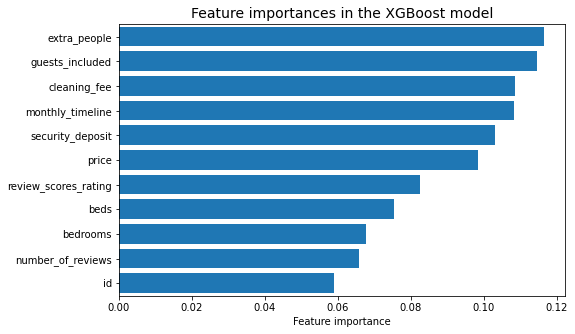

In [210]:
# Producing a dataframe of feature importances
features_weights = pd.DataFrame(xgb_model.feature_importances_, columns=['weight'], index=X_train.columns)
features_weights.sort_values('weight', inplace=True)

# Plotting feature importances
plt.figure(figsize=(8,5))
plt.barh(features_weights.index, features_weights.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()